In [ ]:
!pip install torch transformers pillow opencv-python easyocr scikit-learn matplotlib seaborn pandas numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 99.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.8/963.8 kB 65.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.1/292.1 kB 29.6 MB/s eta 0:00:00


In [6]:
import os
import pandas as pd
import numpy as np
import re
import cv2
import copy
import random
import glob
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader,WeightedRandomSampler
from torchvision import transforms
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score,classification_report,confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from PIL import Image,ImageEnhance,ImageFilter,ImageFile
import easyocr
from transformers import AutoTokenizer,AutoModel,ViTFeatureExtractor,ViTModel,pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import Counter
import string
from google.colab import drive
drive.mount('/content/drive')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

ZIP_DIR='/content/drive/MyDrive/Dissertation/images.zip'
UNZIP_IMAGE_DIR='/content/drive/MyDrive/Dissertation/images'
IMAGE_DIR = "/content/drive/MyDrive/Dissertation/images"
CSV_FILE = "/content/drive/MyDrive/Dissertation/labels.csv"
OUTPUT_DIR = "/content/drive/MyDrive/Dissertation/"
CACHE_DIR = "/content/drive/MyDrive/Dissertation/cache"
os.makedirs(OUTPUT_DIR,exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Device: cuda


流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: /content/drive/MyDrive/Dissertation/images/image_2799.png  
  inflating: /content/drive/MyDrive/Dissertation/images/image_28.jpg  
  inflating: /content/drive/MyDrive/Dissertation/images/image_280.jpg  
  inflating: /content/drive/MyDrive/Dissertation/images/image_2800.png  
  inflating: /content/drive/MyDrive/Dissertation/images/image_2801.png  
  inflating: /content/drive/MyDrive/Dissertation/images/image_2802.png  
  inflating: /content/drive/MyDrive/Dissertation/images/image_2803.png  
  inflating: /content/drive/MyDrive/Dissertation/images/image_2804.png  
  inflating: /content/drive/MyDrive/Dissertation/images/image_2805.jpg  
  inflating: /content/drive/MyDrive/Dissertation/images/image_2806.jpg  
  inflating: /content/drive/MyDrive/Dissertation/images/image_2807.jpg  
  inflating: /content/drive/MyDrive/Dissertation/images/image_2808.jpg  
  inflating: /content/drive/MyDrive/Dissertation/images/image_2809.png  
  inflating: /content/drive

Extracting text:  56%|█████▌    | 3135/5593 [11:32<09:36,  4.27images/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Extracting text:  57%|█████▋    | 3163/5593 [11:37<08:28,  4.78images/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Extracting text: 100%|██████████| 5593/5593 [20:31<00:00,  4.54images/s]


Text extraction completed! Success rate: 5556/5593 (99.3%)
EasyOCR initialization successful


Extracting text: 100%|██████████| 699/699 [02:38<00:00,  4.41images/s]


Text extraction completed! Success rate: 695/699 (99.4%)
EasyOCR initialization successful


Extracting text: 100%|██████████| 700/700 [02:34<00:00,  4.53images/s]


Text extraction completed! Success rate: 695/700 (99.3%)
  Raw category counts: [ 121  384 1761 2501  826]
  Minority categories: [0 1 4]
  Enhanced weights: [3.39373633 1.06938046 0.02331869 0.01641912 0.4971454 ]


Some weights of RobertaModel were not initialized from the model checkpoint at j-hartmann/emotion-english-distilroberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model parameters: Total 82,678,533,Trainable 29,502,213

Starting text-only model training...
Category distribution statistics:
  Category 0 (very_negative): 3544
  Category 1 (negative): 3455
  Category 2 (neutral): 348
  Category 3 (positive): 342
  Category 4 (very_positive): 3497
CBFocalLoss settings:
  Number of samples per class: [3544 3455  348  342 3497]
  CB weights: [0.51886693 0.52550738 1.70751094 1.72577266 0.5223421 ]
  Alpha weights: [0.09650113 0.09898698 0.98275862 1.         0.09779811]

Epoch 1/15


Epoch 1 Training: 100%|██████████| 700/700 [01:38<00:00,  7.14batch/s, Loss=0.0666]



Validating...


Validation: 100%|██████████| 44/44 [00:02<00:00, 15.94batch/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",


Validation classification report:
               precision    recall  f1-score   support

very_negative     0.0583    0.4000    0.1017        15
     negative     0.0000    0.0000    0.0000        48
      neutral     0.0000    0.0000    0.0000       220
     positive     0.4167    0.0160    0.0308       313
very_positive     0.1566    0.8544    0.2647       103

     accuracy                         0.1416       699
    macro avg     0.1263    0.2541    0.0794       699
 weighted avg     0.2109    0.1416    0.0550       699


Epoch 1 Results:
Training loss: 0.2438
Training F1: 0.2751
Training Macro F1: 0.1922
Validation loss: 1.7923
Validation accuracy: 0.1416 (14.16%)
Validation F1: 0.0550
Validation Macro F1: 0.0794
IMPROVING ★

Epoch 2/15


Epoch 2 Training: 100%|██████████| 700/700 [01:38<00:00,  7.14batch/s, Loss=0.0707]



Validating...


Validation: 100%|██████████| 44/44 [00:02<00:00, 15.92batch/s]



Validation classification report:
               precision    recall  f1-score   support

very_negative     0.0658    0.3333    0.1099        15
     negative     0.0000    0.0000    0.0000        48
      neutral     0.6000    0.0136    0.0267       220
     positive     0.4444    0.0511    0.0917       313
very_positive     0.1513    0.8447    0.2566       103

     accuracy                         0.1588       699
    macro avg     0.2523    0.2485    0.0970       699
 weighted avg     0.4116    0.1588    0.0896       699


Epoch 2 Results:
Training loss: 0.2285
Training F1: 0.2790
Training Macro F1: 0.1993
Validation loss: 1.4218
Validation accuracy: 0.1588 (15.88%)
Validation F1: 0.0896
Validation Macro F1: 0.0970
IMPROVING ★

Epoch 3/15


Epoch 3 Training: 100%|██████████| 700/700 [01:38<00:00,  7.14batch/s, Loss=0.6474]



Validating...


Validation: 100%|██████████| 44/44 [00:02<00:00, 15.82batch/s]



Validation classification report:
               precision    recall  f1-score   support

very_negative     0.0432    0.4667    0.0791        15
     negative     0.0000    0.0000    0.0000        48
      neutral     1.0000    0.0045    0.0090       220
     positive     0.3333    0.0032    0.0063       313
very_positive     0.1522    0.7476    0.2529       103

     accuracy                         0.1230       699
    macro avg     0.3057    0.2444    0.0695       699
 weighted avg     0.4873    0.1230    0.0446       699


Epoch 3 Results:
Training loss: 0.2159
Training F1: 0.2862
Training Macro F1: 0.1998
Validation loss: 1.5314
Validation accuracy: 0.1230 (12.30%)
Validation F1: 0.0446
Validation Macro F1: 0.0695
No improvement (1/6)

Epoch 4/15


Epoch 4 Training: 100%|██████████| 700/700 [01:38<00:00,  7.14batch/s, Loss=0.0572]



Validating...


Validation: 100%|██████████| 44/44 [00:02<00:00, 15.92batch/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",


Validation classification report:
               precision    recall  f1-score   support

very_negative     0.0473    0.5333    0.0870        15
     negative     0.0612    0.1875    0.0923        48
      neutral     0.6000    0.0136    0.0267       220
     positive     0.0000    0.0000    0.0000       313
very_positive     0.1534    0.5631    0.2412       103

     accuracy                         0.1116       699
    macro avg     0.1724    0.2595    0.0894       699
 weighted avg     0.2167    0.1116    0.0521       699


Epoch 4 Results:
Training loss: 0.2115
Training F1: 0.3009
Training Macro F1: 0.2107
Validation loss: 1.4807
Validation accuracy: 0.1116 (11.16%)
Validation F1: 0.0521
Validation Macro F1: 0.0894
No improvement (2/6)

Epoch 5/15


Epoch 5 Training: 100%|██████████| 700/700 [01:38<00:00,  7.14batch/s, Loss=0.0899]



Validating...


Validation: 100%|██████████| 44/44 [00:02<00:00, 15.91batch/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",


Validation classification report:
               precision    recall  f1-score   support

very_negative     0.0339    0.5333    0.0637        15
     negative     0.0660    0.5625    0.1182        48
      neutral     0.0000    0.0000    0.0000       220
     positive     0.0000    0.0000    0.0000       313
very_positive     0.1296    0.0680    0.0892       103

     accuracy                         0.0601       699
    macro avg     0.0459    0.2328    0.0542       699
 weighted avg     0.0244    0.0601    0.0226       699


Epoch 5 Results:
Training loss: 0.2073
Training F1: 0.3001
Training Macro F1: 0.2035
Validation loss: 1.5172
Validation accuracy: 0.0601 (6.01%)
Validation F1: 0.0226
Validation Macro F1: 0.0542
No improvement (3/6)

Epoch 6/15


Epoch 6 Training: 100%|██████████| 700/700 [01:38<00:00,  7.14batch/s, Loss=0.0657]



Validating...


Validation: 100%|██████████| 44/44 [00:02<00:00, 15.92batch/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",


Validation classification report:
               precision    recall  f1-score   support

very_negative     0.0259    0.7333    0.0501        15
     negative     0.0648    0.1458    0.0897        48
      neutral     0.0000    0.0000    0.0000       220
     positive     0.0000    0.0000    0.0000       313
very_positive     0.1377    0.2233    0.1704       103

     accuracy                         0.0587       699
    macro avg     0.0457    0.2205    0.0620       699
 weighted avg     0.0253    0.0587    0.0323       699


Epoch 6 Results:
Training loss: 0.2052
Training F1: 0.3052
Training Macro F1: 0.2082
Validation loss: 1.4925
Validation accuracy: 0.0587 (5.87%)
Validation F1: 0.0323
Validation Macro F1: 0.0620
No improvement (4/6)

Epoch 7/15


Epoch 7 Training: 100%|██████████| 700/700 [01:38<00:00,  7.14batch/s, Loss=0.0671]



Validating...


Validation: 100%|██████████| 44/44 [00:02<00:00, 15.92batch/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",


Validation classification report:
               precision    recall  f1-score   support

very_negative     0.0317    0.8667    0.0612        15
     negative     0.0726    0.3542    0.1206        48
      neutral     0.0000    0.0000    0.0000       220
     positive     0.0000    0.0000    0.0000       313
very_positive     0.1455    0.0777    0.1013       103

     accuracy                         0.0544       699
    macro avg     0.0500    0.2597    0.0566       699
 weighted avg     0.0271    0.0544    0.0245       699


Epoch 7 Results:
Training loss: 0.2073
Training F1: 0.3217
Training Macro F1: 0.2149
Validation loss: 1.4507
Validation accuracy: 0.0544 (5.44%)
Validation F1: 0.0245
Validation Macro F1: 0.0566
No improvement (5/6)

Epoch 8/15


Epoch 8 Training: 100%|██████████| 700/700 [01:38<00:00,  7.14batch/s, Loss=0.0550]



Validating...


Validation: 100%|██████████| 44/44 [00:02<00:00, 15.95batch/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",


Validation classification report:
               precision    recall  f1-score   support

very_negative     0.0246    0.6000    0.0472        15
     negative     0.0571    0.3333    0.0976        48
      neutral     1.0000    0.0045    0.0090       220
     positive     0.0000    0.0000    0.0000       313
very_positive     0.1538    0.0777    0.1032       103

     accuracy                         0.0486       699
    macro avg     0.2471    0.2031    0.0514       699
 weighted avg     0.3419    0.0486    0.0258       699


Epoch 8 Results:
Training loss: 0.2060
Training F1: 0.3146
Training Macro F1: 0.2135
Validation loss: 1.3708
Validation accuracy: 0.0486 (4.86%)
Validation F1: 0.0258
Validation Macro F1: 0.0514
No improvement (6/6)

Macro F1-based early stopping triggered! No improvement for 6 consecutive epochs

Training results saved to: /content/drive/MyDrive/Dissertation/text_only_training_results.csv

Loading best model for testing...
Starting final test...


Testing: 100%|██████████| 44/44 [00:02<00:00, 15.90batch/s]



=== Final Test Results (Text-Only) ===
Test accuracy: 0.1443 (14.43%)
Test weighted F1: 0.0880
Test macro F1: 0.0815

Detailed test set classification report:
               precision    recall  f1-score   support

very_negative     0.0263    0.1333    0.0440        15
     negative     0.0000    0.0000    0.0000        48
      neutral     0.5000    0.0227    0.0435       220
     positive     0.4412    0.0479    0.0865       313
very_positive     0.1381    0.7596    0.2337       104

     accuracy                         0.1443       700
    macro avg     0.2211    0.1927    0.0815       700
 weighted avg     0.3755    0.1443    0.0880       700


Generating text attention visualizations...
Processing sample 1...
Saved: /content/drive/MyDrive/Dissertation/text_only_attention_visualization_sample_1.png


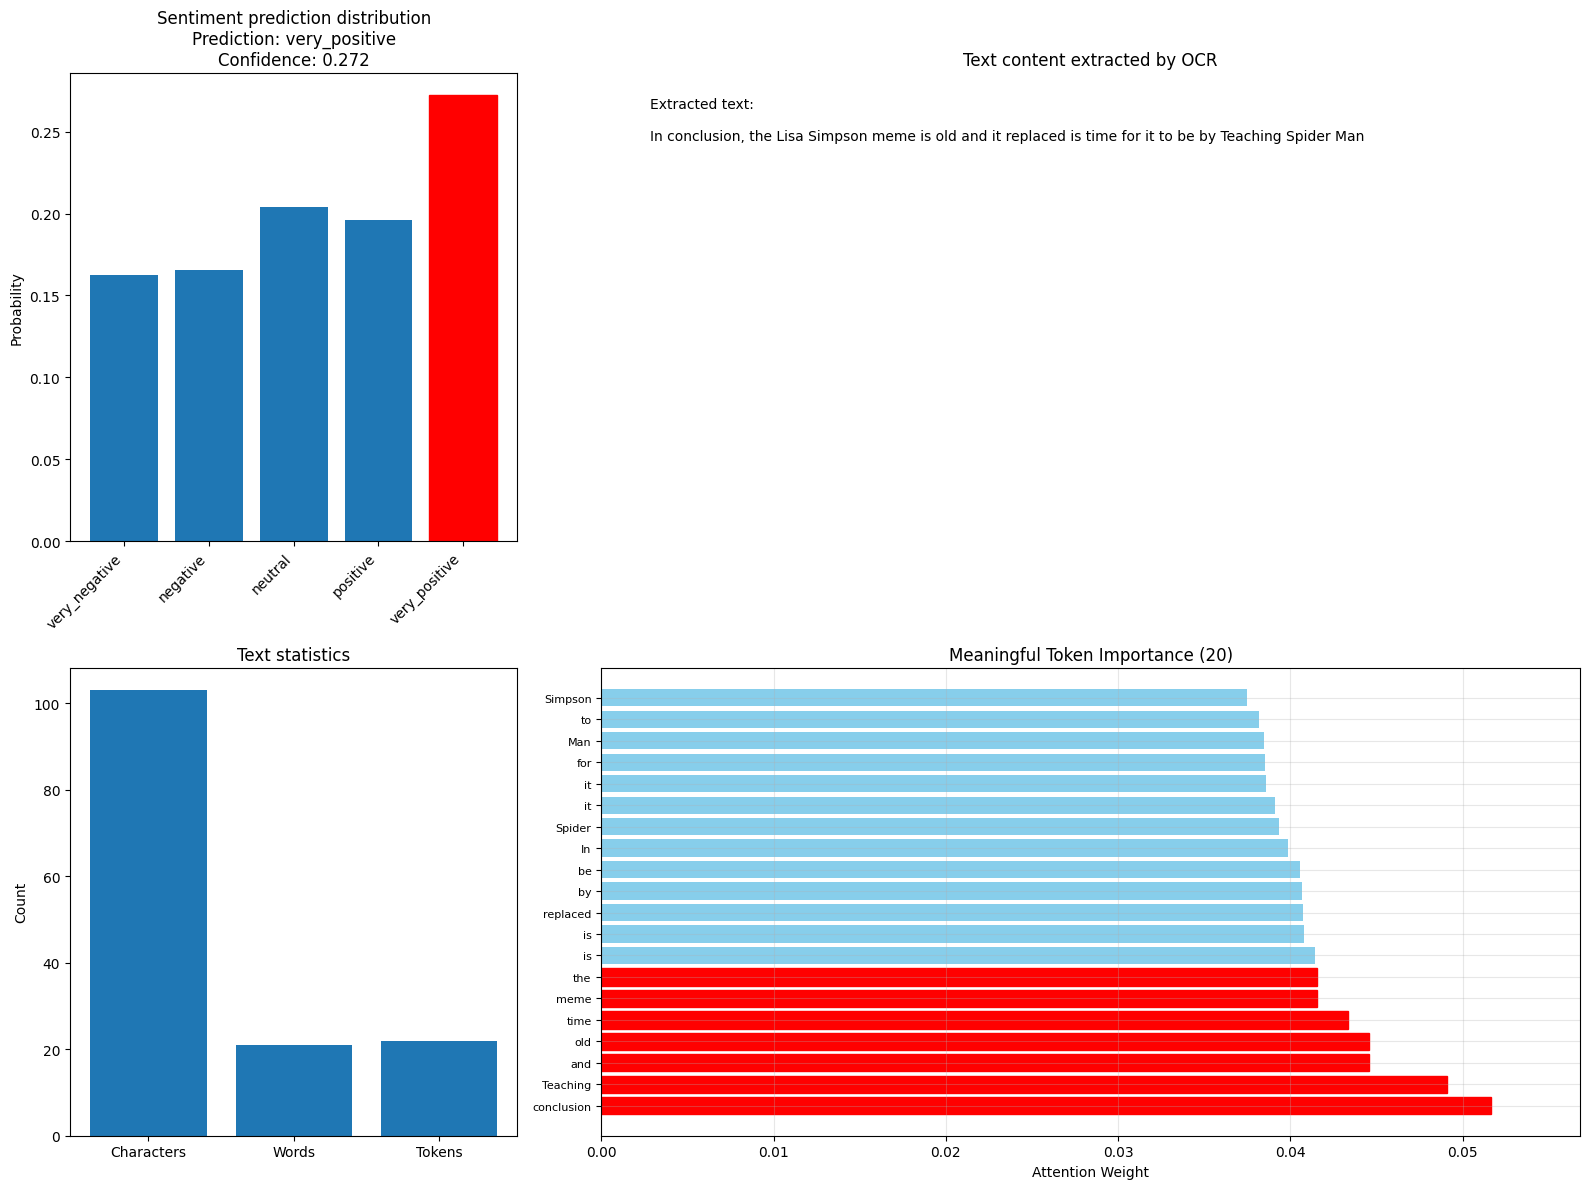

Processing sample 2...
Saved: /content/drive/MyDrive/Dissertation/text_only_attention_visualization_sample_2.png


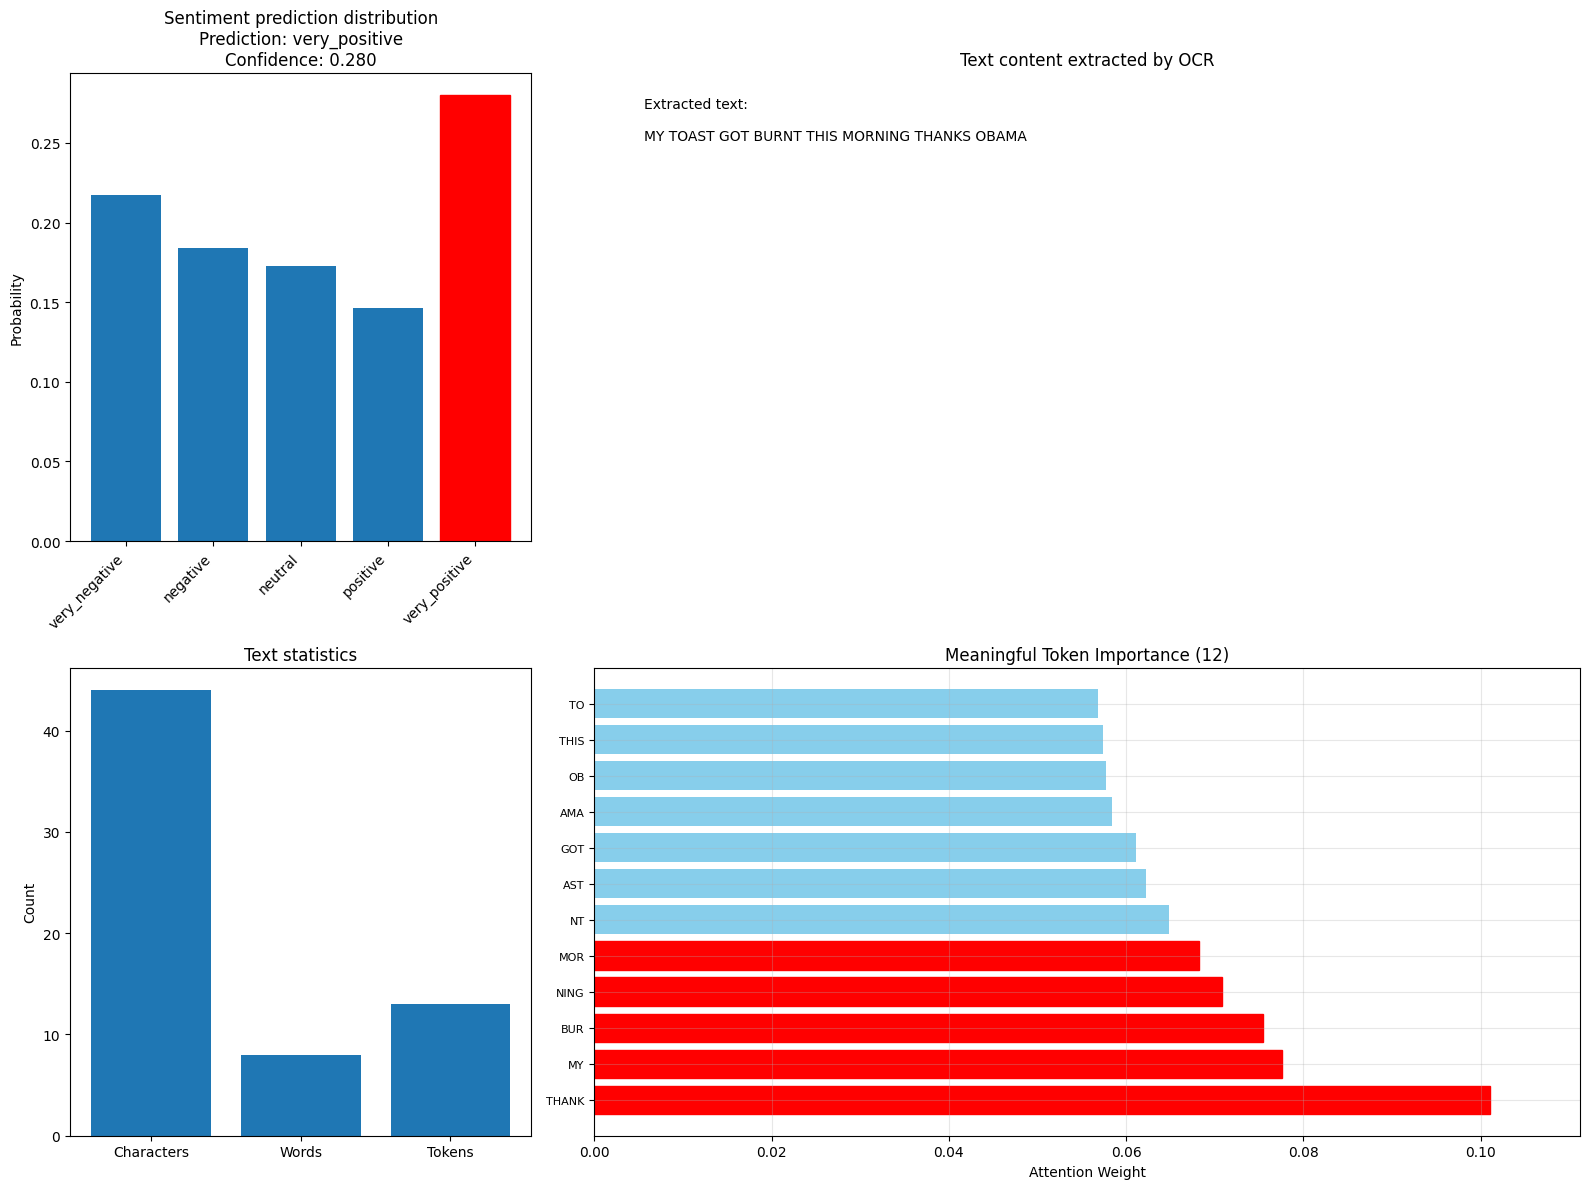

Processing sample 3...
Saved: /content/drive/MyDrive/Dissertation/text_only_attention_visualization_sample_3.png


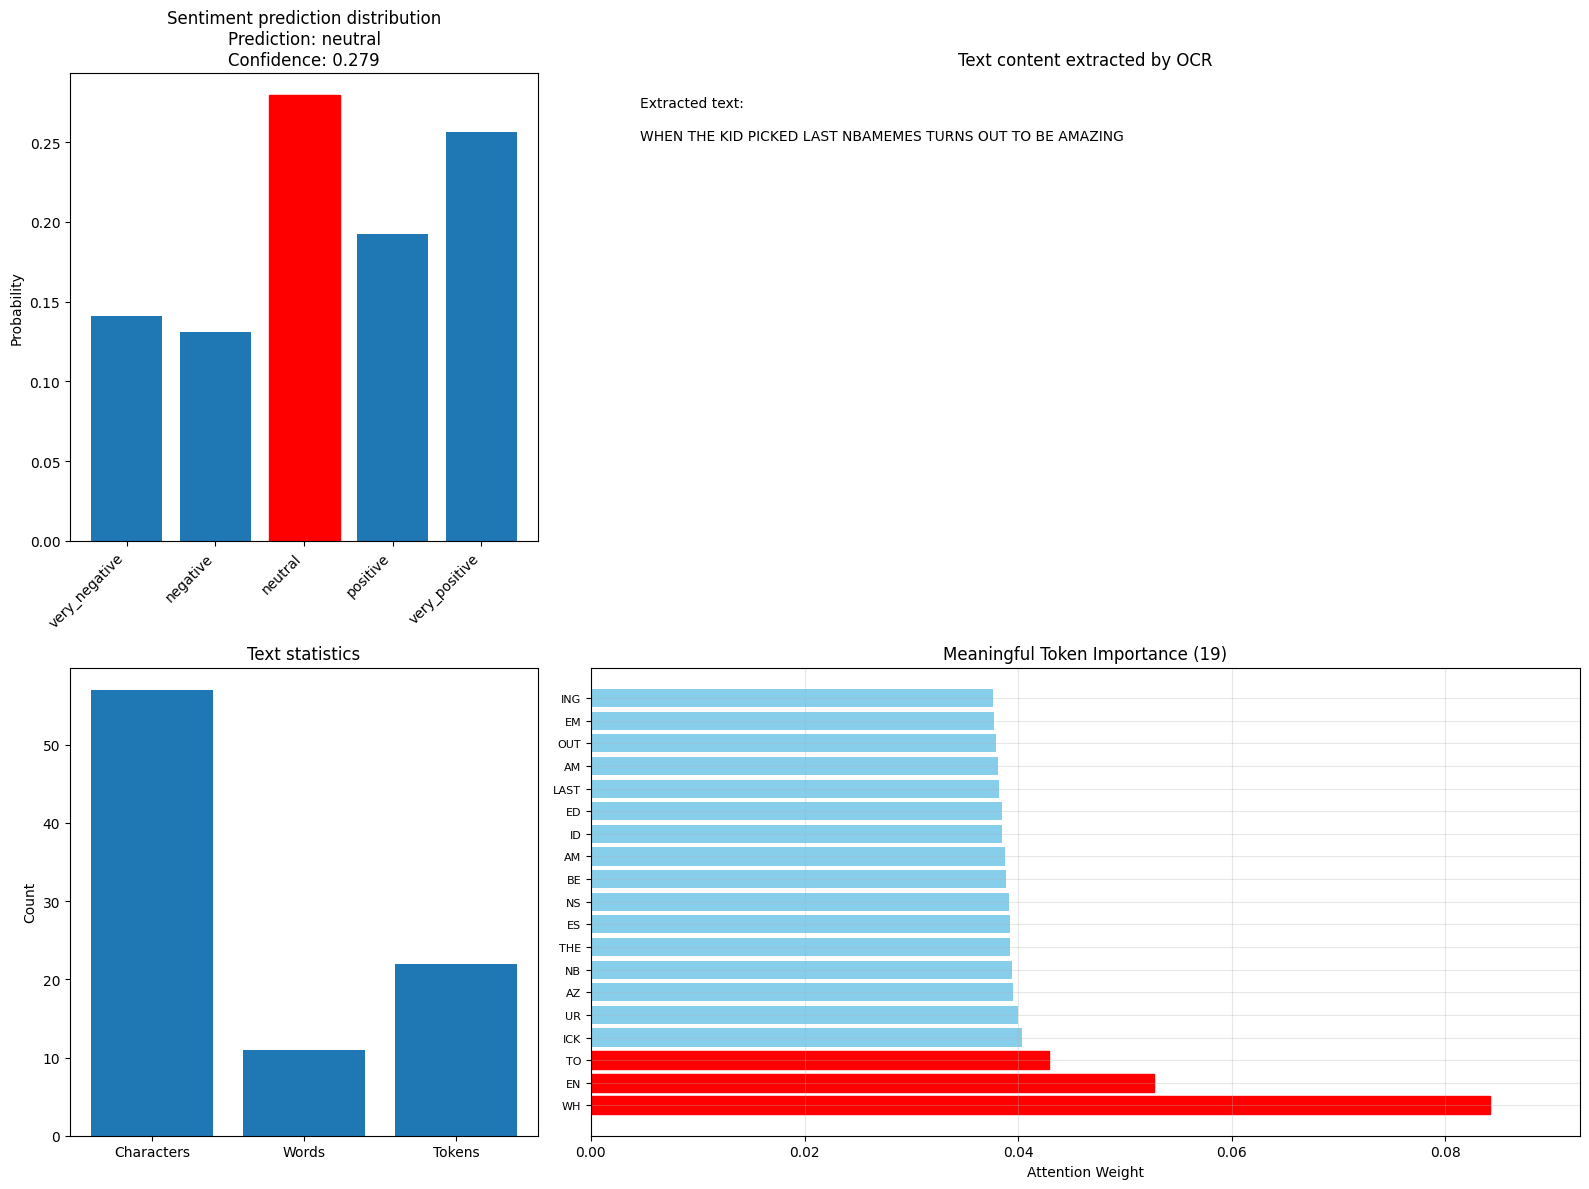

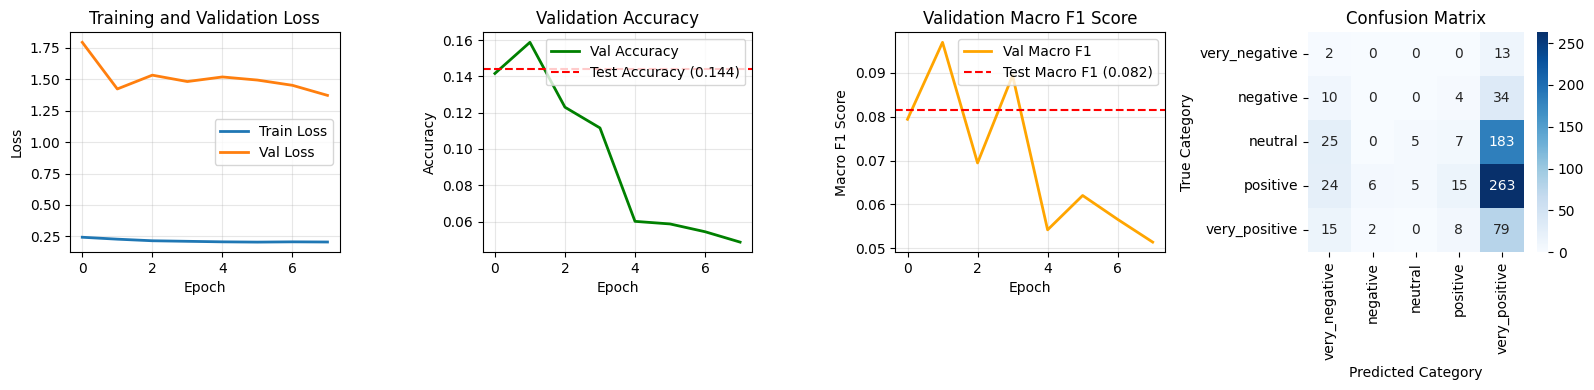


Training completed,files saved to: /content/drive/MyDrive/Dissertation/
Best model: /content/drive/MyDrive/Dissertation/best_text_only_model.pth
Training results CSV: /content/drive/MyDrive/Dissertation/text_only_training_results.csv
Test results CSV: /content/drive/MyDrive/Dissertation/text_only_test_results.csv
Training curves plot: /content/drive/MyDrive/Dissertation/text_only_training_analysis.png
Attention visualizations: /content/drive/MyDrive/Dissertation/text_only_attention_visualization_sample_*.png
Model summary: /content/drive/MyDrive/Dissertation/text_only_model_summary.csv


In [8]:
def unzip_images():
    if os.path.exists(UNZIP_IMAGE_DIR) and os.listdir(UNZIP_IMAGE_DIR):
        print("images already unzipped")
    else:
        !unzip $ZIP_DIR -d $OUTPUT_DIR
        image_paths=glob.glob(os.path.join(UNZIP_IMAGE_DIR,'*.jpg')) + glob.glob(os.path.join(UNZIP_IMAGE_DIR,'*.png'))+glob.glob(os.path.join(UNZIP_IMAGE_DIR,'*.jpeg'))
        # print(f"There are {len(image_paths)} images")

        ImageFile.LOAD_TRUNCATED_IMAGES = True
        Image.MAX_IMAGE_PIXELS = None

        for image in image_paths:
            image_name=os.path.basename(image)
            # print(image_name)
            img = Image.open(image)
            img.load()
            if image.lower().endswith(('.jpg','.jpeg')):
                if img.mode in ['RGBA','P','LA']:
                    if img.mode == 'RGBA':
                        background = Image.new('RGB',img.size,(255,255,255))
                        background.paste(img,mask=img.split()[-1])
                        img = background
                    else:
                        img = img.convert('RGB')
            img.save(image)
# Clean EasyOCR output text
def clean_easyocr_text(text):
    if not text:
        return ""

    text = text.strip()
    text = re.sub(r'[^\w\s.,!?;:()\'-]',' ',text)
    text = ' '.join(text.split())

    if len(text) < 2 or not any(c.isalpha() for c in text):
        return ""

    return text

# Extract meme image text using EasyOCR
def extract_text_with_easyocr(image_path,reader):
    results = reader.readtext(image_path)
    if not results:
        return ""

    sorted_results = sorted(results,key=lambda x: x[0][0][1])
    texts = []
    for bbox,text,confidence in sorted_results:
        if confidence > 0.5:
            cleaned_text = clean_easyocr_text(text)
            if cleaned_text and len(cleaned_text) > 1:
                texts.append(cleaned_text)

    return ' '.join(texts) if texts else ""

# Use EasyOCR after image preprocessing
def extract_with_preprocessing(image_path,reader):
    img = cv2.imread(image_path)
    if img is None:
        return ""

    height,width = img.shape[:2]
    if min(height,width) < 500:
        scale = 500 / min(height,width)
        new_width = int(width * scale)
        new_height = int(height * scale)
        img = cv2.resize(img,(new_width,new_height),interpolation=cv2.INTER_CUBIC)

    lab = cv2.cvtColor(img,cv2.COLOR_BGR2LAB)
    l,a,b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0,tileGridSize=(8,8))
    l = clahe.apply(l)
    enhanced = cv2.merge([l,a,b])
    enhanced = cv2.cvtColor(enhanced,cv2.COLOR_LAB2BGR)

    results = reader.readtext(enhanced)
    texts = []
    for bbox,text,confidence in results:
        if confidence > 0.3:
            cleaned_text = clean_easyocr_text(text)
            if cleaned_text and len(cleaned_text) > 1:
                texts.append(cleaned_text)

    if results:
        sorted_results = sorted(
            [(bbox,text,conf) for bbox,text,conf in results if conf > 0.3],
            key=lambda x: x[0][0][1]
        )
        texts = [clean_easyocr_text(text) for bbox,text,conf in sorted_results
                if clean_easyocr_text(text) and len(clean_easyocr_text(text)) > 1]

    return ' '.join(texts) if texts else ""

# Combine multiple methods to extract meme text
def extract_meme_text(image_path,reader):
    text1 = extract_text_with_easyocr(image_path,reader)
    text2 = extract_with_preprocessing(image_path,reader)

    if len(text2) > len(text1) and len(text2) > 5:
        return text2
    elif len(text1) > 5:
        return text1
    else:
        return text2 if len(text2) > len(text1) else text1

class TextOnlyDataset(Dataset):
    def __init__(self,image_paths,labels,tokenizer,max_length=256):
        self.image_paths = image_paths
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

        # Initialize EasyOCR reader
        try:
            self.ocr_reader = easyocr.Reader(['en'],gpu=torch.cuda.is_available())
            print("EasyOCR initialization successful")
        except Exception as e:
            print(f"EasyOCR initialization error: {e}")
            raise

        # Pre-extract all texts
        self.cached_texts = {}

        for i,path in enumerate(tqdm(image_paths,desc="Extracting text",unit="images")):
            self.cached_texts[path] = self.extract_text_from_image(path)

        success_count = sum(1 for text in self.cached_texts.values() if text and text not in ["[NO_TEXT_FOUND]","[OCR_ERROR]"])
        print(f"Text extraction completed! Success rate: {success_count}/{len(image_paths)} ({success_count/len(image_paths)*100:.1f}%)")

    # Extract text from image using EasyOCR
    def extract_text_from_image(self,image_path):
        try:
            extracted_text = extract_meme_text(image_path,self.ocr_reader)

            if extracted_text:
                extracted_text = extracted_text.replace('\n',' ').replace('\t',' ')
                extracted_text = ' '.join(extracted_text.split())

            return extracted_text.strip() if extracted_text and extracted_text.strip() else "[NO_TEXT_FOUND]"

        except Exception as e:
            print(f"OCR extraction completely failed for {image_path}: {e}")
            return "[OCR_ERROR]"

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self,idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]

        # Get cached text
        text = self.cached_texts.get(image_path,"[NO_TEXT]")

        # Simple text augmentation
        try:
            if isinstance(text,str) and len(text.split()) > 3:
                if random.random() < 0.2:
                    words = text.split()
                    keep = []
                    for w in words:
                        if random.random() < 0.95:
                            keep.append(w)
                    new_text = ' '.join(keep).strip()
                    if len(new_text) >= 2:
                        text = new_text
        except Exception:
            pass

        # Text encoding
        text_encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'text_input_ids': text_encoding['input_ids'].squeeze(),
            'text_attention_mask': text_encoding['attention_mask'].squeeze(),
            'label': torch.tensor(label,dtype=torch.long),
            'text': text,
            'image_path': image_path
        }

# Class-Balanced Focal Loss
class CBFocalLoss(nn.Module):
    def __init__(self,samples_per_class,num_classes,beta=0.99,gamma=2.5,alpha=None,reduction='mean'):
        super(CBFocalLoss,self).__init__()
        samples_per_class = np.maximum(samples_per_class,1)

        effective_num = 1.0 - np.power(beta,samples_per_class)
        weights = (1.0 - beta) / effective_num

        min_samples = np.min(samples_per_class)
        max_samples = np.max(samples_per_class)
        ratio = max_samples / (samples_per_class + 1e-6)

        combined_weights = weights * (ratio ** 0.5)
        combined_weights = combined_weights / np.sum(combined_weights) * num_classes

        self.class_weights = torch.tensor(combined_weights,dtype=torch.float32)
        self.num_classes = num_classes
        self.gamma = gamma
        self.reduction = reduction

        if alpha is None:
            inv_freq = 1.0 / (samples_per_class + 1e-6)
            alpha = inv_freq / inv_freq.sum()
            alpha = alpha / alpha.max()

        self.alpha = torch.tensor(alpha,dtype=torch.float32)

        print(f"CBFocalLoss settings:")
        print(f"  Number of samples per class: {samples_per_class}")
        print(f"  CB weights: {combined_weights}")
        print(f"  Alpha weights: {alpha}")

    def forward(self,logits,labels):
        device = logits.device
        weights = self.class_weights.to(device)
        alpha = self.alpha.to(device)

        log_probs = F.log_softmax(logits,dim=1)
        ce_loss = F.nll_loss(log_probs,labels,reduction='none')

        probs = torch.exp(log_probs)
        pt = probs.gather(1,labels.unsqueeze(1)).squeeze(1)
        pt = torch.clamp(pt,min=1e-7,max=1.0)

        focal_term = (1 - pt) ** self.gamma
        alpha_t = alpha[labels]
        cb_weights = weights[labels]

        loss = alpha_t * cb_weights * focal_term * ce_loss

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss

# Text-only emotion classifier
class TextOnlyClassifier(nn.Module):
    def __init__(self,num_classes=5,hidden_dim=256):
        super(TextOnlyClassifier,self).__init__()

        # Text encoder
        emotion_model_name = 'j-hartmann/emotion-english-distilroberta-base'
        try:
            self.text_encoder = AutoModel.from_pretrained(emotion_model_name)
            self.tokenizer_type = 'emotion-specific'
        except:
            self.text_encoder = AutoModel.from_pretrained('roberta-base')
            self.tokenizer_type = 'roberta'

        self.text_dim = self.text_encoder.config.hidden_size

        # Freeze some layers
        self._freeze_layers()

        # Classification network
        self.classifier = nn.Sequential(
            nn.Linear(self.text_dim,hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(hidden_dim,hidden_dim // 2),
            nn.LayerNorm(hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(hidden_dim // 2,hidden_dim // 4),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(hidden_dim // 4,num_classes)
        )

        self._init_weights()

    def _init_weights(self):
        for m in self.classifier.modules():
            if isinstance(m,nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias,0)

    # Freeze early layers of pretrained model
    def _freeze_layers(self):
        for param in self.text_encoder.embeddings.parameters():
            param.requires_grad = False

        if hasattr(self.text_encoder,'encoder'):
            total_layers = len(self.text_encoder.encoder.layer)
            freeze_layers = min(8,max(total_layers - 4,0))
            for layer in self.text_encoder.encoder.layer[:freeze_layers]:
                for param in layer.parameters():
                    param.requires_grad = False

    def forward(self,text_input_ids,text_attention_mask):
        # Handle RoBERTa special tokens
        if self.tokenizer_type == 'roberta':
            text_input_ids = text_input_ids.masked_fill(text_input_ids == 1,0)

        # Text encoding
        text_outputs = self.text_encoder(
            input_ids=text_input_ids,
            attention_mask=text_attention_mask,
            output_attentions=True
        )

        text_embeddings = text_outputs.last_hidden_state
        text_mask = text_attention_mask.unsqueeze(-1).expand(text_embeddings.size()).float()
        text_features = (text_embeddings * text_mask).sum(1) / text_mask.sum(1)

        # Classification
        logits = self.classifier(text_features)

        # Get attention weights for visualization
        text_attentions = text_outputs.attentions
        if text_attentions and len(text_attentions) > 0:
            last_layer_attention = text_attentions[-1]
            avg_attention = last_layer_attention.mean(dim=1)
            cls_attention = avg_attention[:,0,:]

            masked_attention = cls_attention * text_attention_mask.float()

            for i in range(masked_attention.size(0)):
                valid_positions = text_attention_mask[i].bool()
                if valid_positions.sum() > 1:
                    valid_attn = masked_attention[i][valid_positions]
                    if valid_attn.max() > valid_attn.min():
                        enhanced_attn = torch.softmax(valid_attn * 2.5,dim=0)
                        masked_attention[i][valid_positions] = enhanced_attn

            text_attn_weights = masked_attention
        else:
            text_attn_weights = None

        return logits,text_attn_weights

class EarlyStopping:
    def __init__(self,patience=7,min_delta=0.001,restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_loss = None
        self.counter = 0
        self.best_weights = None

    def __call__(self,val_loss,model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(model)
        else:
            self.counter += 1

        return self.counter >= self.patience

    def save_checkpoint(self,model):
        if self.restore_best_weights:
            self.best_weights = copy.deepcopy(model.state_dict())

    def restore(self,model):
        if self.best_weights is not None:
            model.load_state_dict(self.best_weights)

def calculate_class_distribution(labels,num_classes=5):
    class_counts = np.bincount(labels,minlength=num_classes)
    samples_per_class = class_counts[:num_classes]

    print(f"Category distribution statistics:")
    emotion_labels = ['very_negative','negative','neutral','positive','very_positive']
    for i,count in enumerate(samples_per_class):
        print(f"  Category {i} ({emotion_labels[i]}): {count}")

    return samples_per_class

def create_balanced_sampler(labels,minority_oversample_factor=10):
    labels = np.array(labels)
    class_counts = np.bincount(labels,minlength=5)

    minority_threshold = 900
    minority_classes = np.where(class_counts < minority_threshold)[0]

    base_weights = 1.0 / (class_counts + 1e-6)
    enhanced_weights = base_weights.copy()

    for cls_idx in minority_classes:
        enhanced_weights[cls_idx] *= minority_oversample_factor

    enhanced_weights = enhanced_weights / enhanced_weights.sum() * len(enhanced_weights)
    sample_weights = [enhanced_weights[label] for label in labels]

    print(f"  Raw category counts: {class_counts}")
    print(f"  Minority categories: {minority_classes}")
    print(f"  Enhanced weights: {enhanced_weights}")

    return sample_weights

# Check if token is meaningful
def is_meaningful_token(token,min_length=2):
    clean_token = token.replace('Ġ','').replace('##','').strip()

    if not clean_token or len(clean_token) < min_length:
        return False

    if clean_token in {'<s>','</s>','<pad>','<mask>','[CLS]','[SEP]','<unk>'}:
        return False

    if all(c in string.punctuation for c in clean_token):
        return False

    if not any(c.isalpha() for c in clean_token):
        return False

    return True

# Text attention visualization
def visualize_text_attention(model,sample_data,tokenizer,save_path=None):
    model.eval()

    with torch.no_grad():
        logits,text_attn_weights = model(
            text_input_ids=sample_data['text_input_ids'].unsqueeze(0).to(device),
            text_attention_mask=sample_data['text_attention_mask'].unsqueeze(0).to(device)
        )

        prediction = torch.argmax(logits,dim=1).cpu().item()
        confidence = torch.softmax(logits,dim=1).max().cpu().item()

    emotion_labels = ['very_negative','negative','neutral','positive','very_positive']
    predicted_emotion = emotion_labels[prediction]

    fig = plt.figure(figsize=(16,12))

    # 1. Emotion distribution
    ax1 = plt.subplot(2,3,1)
    probs = torch.softmax(logits,dim=1).squeeze().cpu().numpy()
    bars = ax1.bar(emotion_labels,probs)
    ax1.set_title(f'Sentiment prediction distribution\nPrediction: {predicted_emotion}\nConfidence: {confidence:.3f}')
    ax1.set_ylabel('Probability')
    plt.xticks(rotation=45,ha='right')
    bars[prediction].set_color('red')

    # 2. Extracted text
    ax2 = plt.subplot(2,3,(2,3))
    text = sample_data['text']
    wrapped_text = text[:800] + "..." if len(text) > 800 else text
    ax2.text(0.05,0.95,f"Extracted text:\n\n{wrapped_text}",
            fontsize=10,ha='left',va='top',wrap=True,
            transform=ax2.transAxes)
    ax2.set_title('Text content extracted by OCR',fontsize=12)
    ax2.axis('off')

    # 3. Text length statistics
    ax3 = plt.subplot(2,3,4)
    input_ids = sample_data['text_input_ids'].cpu().numpy()
    tokens = tokenizer.convert_ids_to_tokens(input_ids)
    valid_tokens = [t.replace('Ġ',' ') for t in tokens if t not in ['<s>','</s>','<pad>']]
    text_stats = {
        'Characters': len(text),
        'Words': len(text.split()),
        'Tokens': len(valid_tokens)
    }
    bars = ax3.bar(text_stats.keys(),text_stats.values())
    ax3.set_title('Text statistics')
    ax3.set_ylabel('Count')

    # 4. Token importance analysis
    ax4 = plt.subplot(2,3,(5,6))
    try:
        input_ids = sample_data['text_input_ids'].cpu().numpy()
        attention_mask = sample_data['text_attention_mask'].cpu().numpy()
        tokens = tokenizer.convert_ids_to_tokens(input_ids)

        if text_attn_weights is not None and text_attn_weights.numel() > 1:
            token_attention = text_attn_weights[0].cpu().numpy()

            meaningful_tokens = []
            valid_indices = np.where(attention_mask == 1)[0]

            for idx in valid_indices:
                if idx < len(tokens) and idx < len(token_attention):
                    token = tokens[idx]
                    weight = token_attention[idx]

                    if is_meaningful_token(token):
                        clean_token = token.replace('Ġ','').replace('##','').strip()
                        meaningful_tokens.append((idx,clean_token,float(weight)))

            if meaningful_tokens:
                meaningful_tokens.sort(key=lambda x: x[2],reverse=True)
                meaningful_tokens = meaningful_tokens[:20]  # Show top 20

                indices,display_tokens,weights = zip(*meaningful_tokens)

                y_pos = np.arange(len(display_tokens))
                bars = ax4.barh(y_pos,weights,color='skyblue')
                ax4.set_yticks(y_pos)
                ax4.set_yticklabels(display_tokens,fontsize=8)
                ax4.set_xlabel('Attention Weight')
                ax4.set_title(f'Meaningful Token Importance ({len(meaningful_tokens)})')

                if len(weights) > 1:
                    mean_weight = np.mean(weights)
                    for i,weight in enumerate(weights):
                        if weight > mean_weight:
                            bars[i].set_color('red')

                ax4.set_xlim(0,max(weights) * 1.1)
            else:
                ax4.text(0.5,0.5,'No meaningful tokens found\nafter filtering',
                        ha='center',va='center')

        ax4.grid(True,alpha=0.3)

    except Exception as e:
        ax4.text(0.5,0.5,f'Token analysis failed\n{str(e)[:50]}...',
                ha='center',va='center')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path,dpi=300,bbox_inches='tight')
        print(f"Saved: {save_path}")
    plt.show()

# Train text-only model
def train_text_only_model(model,train_loader,val_loader,num_epochs=15,learning_rate=2e-5,save_dir=OUTPUT_DIR):
    # Calculate class distribution
    all_labels = []
    for batch in train_loader:
        all_labels.extend(batch['label'].tolist())
    samples_per_class = calculate_class_distribution(all_labels,num_classes=5)

    # Loss function
    criterion = CBFocalLoss(
        samples_per_class=samples_per_class,
        num_classes=5,
        beta=0.99,
        gamma=2.5,
        alpha=None
    )

    # Optimizer
    optimizer = optim.AdamW([
        {'params': model.text_encoder.parameters(),'lr': learning_rate * 0.01,'weight_decay': 1e-3},
        {'params': model.classifier.parameters(),'lr': learning_rate,'weight_decay': 2e-3}
    ],eps=1e-8,betas=(0.9,0.999))

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,mode='max',factor=0.8,patience=3,min_lr=1e-7
    )

    # Early stopping
    early_stopping = EarlyStopping(patience=6,min_delta=0.002)
    best_val_macro_f1 = 0
    patience = 6
    patience_counter = 0

    # Record training process
    train_losses = []
    val_losses = []
    val_accuracies = []
    val_f1_scores = []
    val_macro_f1_scores = []
    training_results = []

    emotion_labels = ['very_negative','negative','neutral','positive','very_positive']

    for epoch in range(num_epochs):
        print(f"\n{'='*60}")
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"{'='*60}")

        # Training phase
        model.train()
        total_train_loss = 0
        all_train_predictions = []
        all_train_labels = []
        num_batches = 0

        train_pbar = tqdm(train_loader,desc=f"Epoch {epoch+1} Training",unit="batch")

        for batch in train_pbar:
            optimizer.zero_grad()

            logits,_ = model(
                text_input_ids=batch['text_input_ids'].to(device),
                text_attention_mask=batch['text_attention_mask'].to(device)
            )
            labels = batch['label'].to(device)

            # Main loss
            loss = criterion(logits,labels)

            # L1 regularization
            l1_reg = torch.tensor(0.,requires_grad=True)
            for name,param in model.named_parameters():
                if 'weight' in name and 'encoder' not in name:
                    l1_reg = l1_reg + torch.norm(param,1)

            total_loss = loss + 1e-6 * l1_reg

            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(),max_norm=0.3)
            optimizer.step()

            total_train_loss += total_loss.item()
            num_batches += 1

            predictions = torch.argmax(logits,dim=1).cpu().numpy()
            labels_np = labels.cpu().numpy()
            all_train_predictions.extend(predictions)
            all_train_labels.extend(labels_np)

            train_pbar.set_postfix({'Loss': f'{total_loss.item():.4f}'})

        # Calculate training metrics
        avg_train_loss = total_train_loss / num_batches
        train_f1 = f1_score(all_train_labels,all_train_predictions,average='weighted')
        train_macro_f1 = f1_score(all_train_labels,all_train_predictions,average='macro')
        train_losses.append(avg_train_loss)

        # Validation phase
        print("\nValidating...")
        model.eval()
        total_val_loss = 0
        all_val_predictions = []
        all_val_labels = []

        with torch.no_grad():
            for batch in tqdm(val_loader,desc="Validation",unit="batch"):
                logits,_ = model(
                    text_input_ids=batch['text_input_ids'].to(device),
                    text_attention_mask=batch['text_attention_mask'].to(device)
                )
                labels = batch['label'].to(device)
                loss = criterion(logits,labels)
                total_val_loss += loss.item()

                predictions = torch.argmax(logits,dim=1).cpu().numpy()
                labels_np = labels.cpu().numpy()
                all_val_predictions.extend(predictions)
                all_val_labels.extend(labels_np)

        # Calculate validation metrics
        avg_val_loss = total_val_loss / len(val_loader)
        val_accuracy = accuracy_score(all_val_labels,all_val_predictions)
        val_f1 = f1_score(all_val_labels,all_val_predictions,average='weighted')
        val_macro_f1 = f1_score(all_val_labels,all_val_predictions,average='macro')

        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)
        val_f1_scores.append(val_f1)
        val_macro_f1_scores.append(val_macro_f1)

        scheduler.step(val_macro_f1)

        # Generate validation classification report
        val_report = classification_report(all_val_labels,all_val_predictions,target_names=emotion_labels,digits=4)
        print(f"\nValidation classification report:")
        print(val_report)

        # Check improvement
        improved = ""
        if val_macro_f1 > best_val_macro_f1:
            best_val_macro_f1 = val_macro_f1
            patience_counter = 0
            improved = "IMPROVING ★"
            torch.save(model.state_dict(),os.path.join(save_dir,'best_text_only_model.pth'))
        else:
            patience_counter += 1
            improved = f"No improvement ({patience_counter}/{patience})"

        print(f"\nEpoch {epoch+1} Results:")
        print(f"Training loss: {avg_train_loss:.4f}")
        print(f"Training F1: {train_f1:.4f}")
        print(f"Training Macro F1: {train_macro_f1:.4f}")
        print(f"Validation loss: {avg_val_loss:.4f}")
        print(f"Validation accuracy: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")
        print(f"Validation F1: {val_f1:.4f}")
        print(f"Validation Macro F1: {val_macro_f1:.4f}")
        print(f"{improved}")

        training_results.append({
            'epoch': epoch + 1,
            'train_loss': avg_train_loss,
            'train_f1': train_f1,
            'train_macro_f1': train_macro_f1,
            'val_loss': avg_val_loss,
            'val_accuracy': val_accuracy,
            'val_f1': val_f1,
            'val_macro_f1': val_macro_f1,
            'best_val_macro_f1': best_val_macro_f1,
            'patience_counter': patience_counter,
            'improved': improved
        })

        # Early stopping check
        if early_stopping(avg_val_loss,model):
            print(f"\nEarly stopping triggered! No improvement for {early_stopping.patience} consecutive epochs")
            early_stopping.restore(model)
            break

        if patience_counter >= patience:
            print(f"\nMacro F1-based early stopping triggered! No improvement for {patience} consecutive epochs")
            break

    results_df = pd.DataFrame(training_results)
    results_csv_path = os.path.join(save_dir,'text_only_training_results.csv')
    results_df.to_csv(results_csv_path,index=False)
    print(f"\nTraining results saved to: {results_csv_path}")

    return train_losses,val_losses,val_accuracies,val_f1_scores,val_macro_f1_scores

def prepare_data(labels_csv_path,images_dir):
    df = pd.read_csv(labels_csv_path)
    print(f"Original dataset size: {len(df)}")

    emotion_map = {
        'very_positive': 4,
        'positive': 3,
        'neutral': 2,
        'negative': 1,
        'very_negative': 0
    }

    df['emotion_id'] = df['overall_sentiment'].map(emotion_map)
    df['full_path'] = df['image_name'].apply(lambda x: os.path.join(images_dir,x))

    existing_files = df[df['full_path'].apply(os.path.exists)]
    print(f"Existing image files: {len(existing_files)}")

    return existing_files

def main():
    df = prepare_data(CSV_FILE,IMAGE_DIR)

    train_df,temp_df = train_test_split(df,test_size=0.2,random_state=42,stratify=df['emotion_id'])
    val_df,test_df = train_test_split(temp_df,test_size=0.5,random_state=42,stratify=temp_df['emotion_id'])

    print(f"Data distribution:")
    print(f"  Training set: {len(train_df)} samples")
    print(f"  Validation set: {len(val_df)} samples")
    print(f"  Test set: {len(test_df)} samples")

    try:
        tokenizer = AutoTokenizer.from_pretrained('j-hartmann/emotion-english-distilroberta-base')
    except:
        tokenizer = AutoTokenizer.from_pretrained('roberta-base')

    train_dataset = TextOnlyDataset(
        train_df['full_path'].tolist(),
        train_df['emotion_id'].tolist(),
        tokenizer,
        max_length=256
    )

    val_dataset = TextOnlyDataset(
        val_df['full_path'].tolist(),
        val_df['emotion_id'].tolist(),
        tokenizer,
        max_length=256
    )

    test_dataset = TextOnlyDataset(
        test_df['full_path'].tolist(),
        test_df['emotion_id'].tolist(),
        tokenizer,
        max_length=256
    )

    sample_weights = create_balanced_sampler(train_df['emotion_id'].tolist(),minority_oversample_factor=10)

    total_samples = len(train_df)
    num_samples_per_epoch = max(total_samples * 2,8000)
    sampler = WeightedRandomSampler(sample_weights,num_samples=num_samples_per_epoch,replacement=True)

    train_loader = DataLoader(train_dataset,batch_size=16,sampler=sampler,num_workers=2)
    val_loader = DataLoader(val_dataset,batch_size=16,shuffle=False,num_workers=2)
    test_loader = DataLoader(test_dataset,batch_size=16,shuffle=False,num_workers=2)

    model = TextOnlyClassifier(num_classes=5,hidden_dim=512)
    model.to(device)

    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Model parameters: Total {total_params:,},Trainable {trainable_params:,}")

    print(f"\nStarting text-only model training...")
    train_losses,val_losses,val_accuracies,val_f1_scores,val_macro_f1_scores = train_text_only_model(
        model,train_loader,val_loader,num_epochs=15,learning_rate=2e-5
    )

    # Load best model for testing
    print(f"\nLoading best model for testing...")
    model.load_state_dict(torch.load(os.path.join(OUTPUT_DIR,'best_text_only_model.pth')))
    model.eval()

    all_test_predictions = []
    all_test_labels = []

    print("Starting final test...")
    with torch.no_grad():
        for batch in tqdm(test_loader,desc="Testing",unit="batch"):
            logits,_ = model(
                text_input_ids=batch['text_input_ids'].to(device),
                text_attention_mask=batch['text_attention_mask'].to(device)
            )
            predictions = torch.argmax(logits,dim=1).cpu().numpy()
            labels = batch['label'].cpu().numpy()

            all_test_predictions.extend(predictions)
            all_test_labels.extend(labels)

    # Calculate final metrics
    test_accuracy = accuracy_score(all_test_labels,all_test_predictions)
    test_f1 = f1_score(all_test_labels,all_test_predictions,average='weighted')
    test_macro_f1 = f1_score(all_test_labels,all_test_predictions,average='macro')

    print(f"\n=== Final Test Results (Text-Only) ===")
    print(f"Test accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
    print(f"Test weighted F1: {test_f1:.4f}")
    print(f"Test macro F1: {test_macro_f1:.4f}")

    emotion_labels = ['very_negative','negative','neutral','positive','very_positive']
    test_report = classification_report(all_test_labels,all_test_predictions,
                                       target_names=emotion_labels,digits=4)
    print(f"\nDetailed test set classification report:")
    print(test_report)

    test_results = {
        'model_type': 'text_only',
        'test_accuracy': test_accuracy,
        'test_f1': test_f1,
        'test_macro_f1': test_macro_f1,
        'classification_report': test_report
    }

    test_results_df = pd.DataFrame([test_results])
    test_csv_path = os.path.join(OUTPUT_DIR,'text_only_test_results.csv')
    test_results_df.to_csv(test_csv_path,index=False)

    # Generate text attention visualizations
    print(f"\nGenerating text attention visualizations...")
    for i in range(min(3,len(test_dataset))):
        sample_data = test_dataset[i]
        save_path = os.path.join(OUTPUT_DIR,f'text_only_attention_visualization_sample_{i+1}.png')
        print(f"Processing sample {i+1}...")
        visualize_text_attention(model,sample_data,tokenizer,save_path=save_path)

    # Plot training curves and confusion matrix
    plt.figure(figsize=(16,4))

    plt.subplot(1,4,1)
    plt.plot(train_losses,label='Train Loss',linewidth=2)
    plt.plot(val_losses,label='Val Loss',linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True,alpha=0.3)

    plt.subplot(1,4,2)
    plt.plot(val_accuracies,label='Val Accuracy',color='green',linewidth=2)
    plt.axhline(y=test_accuracy,color='red',linestyle='--',label=f'Test Accuracy ({test_accuracy:.3f})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()
    plt.grid(True,alpha=0.3)

    plt.subplot(1,4,3)
    plt.plot(val_macro_f1_scores,label='Val Macro F1',color='orange',linewidth=2)
    plt.axhline(y=test_macro_f1,color='red',linestyle='--',label=f'Test Macro F1 ({test_macro_f1:.3f})')
    plt.xlabel('Epoch')
    plt.ylabel('Macro F1 Score')
    plt.title('Validation Macro F1 Score')
    plt.legend()
    plt.grid(True,alpha=0.3)

    # Confusion matrix
    plt.subplot(1,4,4)
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(all_test_labels,all_test_predictions)
    sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',
                xticklabels=emotion_labels,yticklabels=emotion_labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Category')
    plt.ylabel('True Category')

    plt.tight_layout()
    training_plot_path = os.path.join(OUTPUT_DIR,'text_only_training_analysis.png')
    plt.savefig(training_plot_path,dpi=300,bbox_inches='tight')
    plt.show()

    final_summary = {
        'model_name': 'Text Only Emotion Classifier',
        'total_params': total_params,
        'trainable_params': trainable_params,
        'train_samples': len(train_df),
        'val_samples': len(val_df),
        'test_samples': len(test_df),
        'final_test_accuracy': test_accuracy,
        'final_test_f1': test_f1,
        'final_test_macro_f1': test_macro_f1,
        'best_val_f1': max(val_f1_scores) if val_f1_scores else 0,
        'epochs_trained': len(train_losses),
        'ocr_method': 'EasyOCR',
        'text_encoder': 'j-hartmann/emotion-english-distilroberta-base'
    }

    summary_df = pd.DataFrame([final_summary])
    summary_csv_path = os.path.join(OUTPUT_DIR,'text_only_model_summary.csv')
    summary_df.to_csv(summary_csv_path,index=False)

    print(f"\nTraining completed,files saved to: {OUTPUT_DIR}")
    print(f"Best model: {OUTPUT_DIR}best_text_only_model.pth")
    print(f"Training results CSV: {OUTPUT_DIR}text_only_training_results.csv")
    print(f"Test results CSV: {OUTPUT_DIR}text_only_test_results.csv")
    print(f"Training curves plot: {OUTPUT_DIR}text_only_training_analysis.png")
    print(f"Attention visualizations: {OUTPUT_DIR}text_only_attention_visualization_sample_*.png")
    print(f"Model summary: {OUTPUT_DIR}text_only_model_summary.csv")

if __name__ == "__main__":
    unzip_images()
    main()